# Training a neural network on QM9

This tutorial will explain how to use SchNetPack for training a model
on the QM9 dataset and how the trained model can be used for further.

First, we import the necessary modules and create a new directory for the data and our model.

In [1]:
import os
import schnetpack as spk

qm9tut = './qm9tut'
if not os.path.exists('qm9tut'):
    os.makedirs(qm9tut)

## Loading the data

As explained in the [previous tutorial](preparedata.ipynb), datasets in SchNetPack are loaded with the `AtomsLoader` class or one of the sub-classes that are specialized for common benchmark datasets. 
The `QM9` dataset class will download and convert the data. We will only use the inner energy at 0K `U0`, so all other properties do not need to be loaded:

In [2]:
from schnetpack.datasets import QM9

qm9data = QM9('./qm9.db', download=True, load_only=[QM9.U0], remove_uncharacterized=True)

### Splitting the data

Next, we split the data into training, validation and test set. Here, we choose to use 1000 training examples, 1000 examples for validation and the remaining data as test set.
The corresponding indices are stored in the `split.npz` file.

In [3]:
train, val, test = spk.train_test_split(
        data=qm9data,
        num_train=1000,
        num_val=500,
        split_file=os.path.join(qm9tut, "split.npz"),
    )

Next, we will create an `AtomsLoader` for each split. 
This will take care of shuffling, batching and asynchronously loading the data during training and evaluation.

In [4]:
train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=100)

### Dataset statistics

Before building the model, we need some statistic about our target property for good initial conditions. We will get this from the training examples.
For QM9, we also have single-atom reference values stored in the metadata:

In [5]:
atomrefs = qm9data.get_atomrefs(QM9.U0)
print('U0 of hyrogen:', '{:.2f}'.format(atomrefs[QM9.U0][1][0]), 'eV')
print('U0 of carbon:', '{:.2f}'.format(atomrefs[QM9.U0][6][0]), 'eV')
print('U0 of oxygen:', '{:.2f}'.format(atomrefs[QM9.U0][8][0]), 'eV')

U0 of hyrogen: -13.61 eV
U0 of carbon: -1029.86 eV
U0 of oxygen: -2042.61 eV


These can be used together with the mean and standard deviation of the energy per atom to initialize the model with a good guess of the energy of a molecule. When calculating these statistics, we pass the atomref to take into account, that the model will add these atomrefs to the predicted energy later, so that this part of the energy does not have to be considered in the statistics, i.e.
\begin{equation}
\mu_{U_0} = \frac{1}{n_\text{train}} \sum_{n=1}^{n_\text{train}} \left( U_{0,n} - \sum_{i=1}^{n_{\text{atoms},n}} U_{0,Z_{n,i}} \right)
\end{equation}
for the mean and analog for the standard deviation. In this case, this corresponds to the mean and std. dev of the *atomization energy* per atom.

In [6]:
means, stddevs = train_loader.get_statistics(
    QM9.U0, get_atomwise_statistics=True, single_atom_ref=atomrefs
)
print('Mean atomization energy / atom:', means[QM9.U0])
print('Std. dev. atomization energy / atom:', stddevs[QM9.U0])

Mean atomization energy / atom: tensor([-4.2497])
Std. dev. atomization energy / atom: tensor([0.1967])


## Building the model

The next step is to build the neural network model.
This consists of 2 parts:

1. The representation part which either constructs atom-wise features, e.g. with SchNet, or build a fixed descriptor such as atom-centered symmetry functions.
2. One or more output modules for property prediction.

We will use a `SchNet` module with 3 interaction layers, a 5 Angstrom cosine cutoff with pairwise distances expanded on 20 Gaussians and 50 atomwise features and convolution filters here, since we only have a few training examples (click [here](../modules/representation.rst#module-schnetpack.representation.schnet) for details on SchNet). Then, we will use one `Atomwise` modules to predict the energy, which takes mean and standard deviation per atom of the property for initialization. Both modules are then combined to an `AtomisticModel`.

In [7]:
schnet = spk.representation.SchNet(
    n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=5,
    cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
)

output_U0 = spk.atomistic.Atomwise(n_in=30, atomref=atomrefs[QM9.U0], property=QM9.U0,
                                   mean=means[QM9.U0], stddev=stddevs[QM9.U0])
model = spk.AtomisticModel(representation=schnet, output_modules=output_U0)

## Training the model

To train the model, we will use the `Trainer` class that comes with SchNetPack.
For this, we need to first define a loss function and select an optimizer.
As the loss function, we will use the mean squared error of the energy
$\ell(E_\text{ref}, E_\text{pred}) = \frac{1}{n_\text{train}} \sum_{n=1}^{n_\text{train}} (E_\text{ref} - E_\text{pred})^2$

This will be minimized using the Adam optimizer from PyTorch.

In [8]:
from torch.optim import Adam

# loss function
def mse_loss(batch, result):
    diff = batch[QM9.U0]-result[QM9.U0]
    err_sq = torch.mean(diff ** 2)
    return err_sq

# build optimizer
optimizer = Adam(model.parameters(), lr=1e-2)

We can give the `Trainer` hooks, that are called at certain points during the training loop.
This is useful to customize the training process, e.g. with logging, learning rate schedules or stopping criteria.
Here, we set up a basis logging as well as a learning rate schedule that reduces the learning rate by factor 0.8 after 5 epochs without improvement of the validation loss.

The logger takes a list of validation metrics that specify what is going to be stored.
In this example, we want to log the mean absolute and root mean squared error of the $U_0$ energy prediction.

In [9]:
# before setting up the trainer, remove previous training checkpoints and logs
%rm -r ./qm9tut/checkpoints
%rm -r ./qm9tut/log.csv

import schnetpack.train as trn

loss = trn.build_mse_loss([QM9.U0])

metrics = [spk.metrics.MeanAbsoluteError(QM9.U0)]
hooks = [
    trn.CSVHook(log_path=qm9tut, metrics=metrics), 
    trn.ReduceLROnPlateauHook(
        optimizer, 
        patience=5, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

trainer = trn.Trainer(
    model_path=qm9tut,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

We can run the training for a given number of epochs. If we don't give a number, the trainer runs until a stopping criterion is met. For the purpose of this tutorial, we let it train for 200 epochs (on GPU this should take about x minutes).

In [10]:
device = "cuda" # change to 'cpu' if gpu is not available
n_epochs = 300 # takes about 10 min on a notebook GPU. reduces for playing around
trainer.train(device=device, n_epochs=n_epochs)

You can also call this method several times to continue training. For the training to run until convergence, remove the n_epochs argument or set it to a very large number.

Let us finally have a look at the CSV log:

Final validation MAE: 0.13 eV = 3.09 kcal/mol


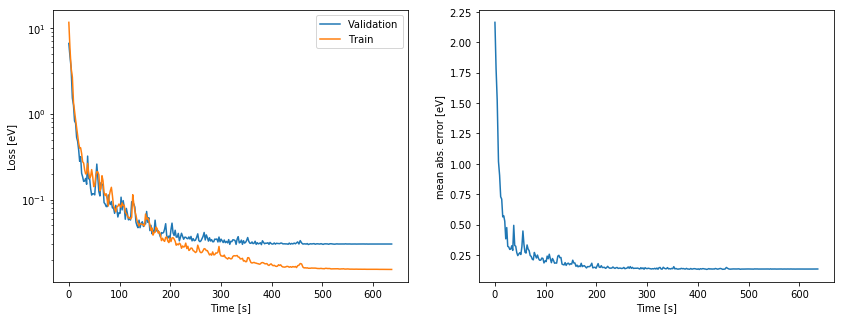

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from ase.units import kcal, mol

results = np.loadtxt(os.path.join(qm9tut, 'log.csv'), skiprows=1, delimiter=',')

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

print('Final validation MAE:', np.round(val_mae[-1], 2), 'eV =',
      np.round(val_mae[-1] / (kcal/mol), 2), 'kcal/mol')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(time, val_loss, label='Validation')
plt.plot(time, train_loss, label='Train')
plt.yscale('log')
plt.ylabel('Loss [eV]')
plt.xlabel('Time [s]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, val_mae)
plt.ylabel('mean abs. error [eV]')
plt.xlabel('Time [s]')
plt.show()

Of course, the prediction can be improved by letting the training run longer, increasing the patience, the number of neurons and interactions or using regularization techniques.

## Using the model

Having trained a model for QM9, we are going to use it to obtain some predictions.
First, we need to load the model. The `Trainer` stores the best model in the model directory which can be loaded using PyTorch:

In [13]:
import torch
best_model = torch.load(os.path.join(qm9tut, 'best_model'))

To evaluate it on the test data, we create a data loader for the test split:

In [14]:
test_loader = spk.AtomsLoader(test, batch_size=100)

err = 0
print(len(test_loader))
for count, batch in enumerate(test_loader):    
    # move batch to GPU, if necessary
    batch = {k: v.to(device) for k, v in batch.items()}
    
    # apply model
    pred = best_model(batch)
    
    # calculate absolute error
    tmp = torch.sum(torch.abs(pred[QM9.U0]-batch[QM9.U0]))
    tmp = tmp.detach().cpu().numpy() # detach from graph & convert to numpy
    err += tmp
    
    # log progress
    percent = '{:3.2f}'.format(count/len(test_loader)*100)
    print('Progress:', percent+'%'+' '*(5-len(percent)), end="\r")
    
err /= len(test)
print('Test MAE', np.round(err, 2), 'eV =',
      np.round(err / (kcal/mol), 2), 'kcal/mol')

1328
Test MAE 0.16 eV = 3.73 kcal/mol


If your data is not already in SchNetPack format, a more convenient way is to use ASE atoms objects with the provided `AtomsConverter`.

In [15]:
converter = spk.data.AtomsConverter(device=device)
at, props = test.get_properties(idx=153)

inputs = converter(at)
print('Keys:', list(inputs.keys()))
print('Truth:', props[QM9.U0].cpu().numpy()[0])

pred = model(inputs)

print('Prediction:', pred[QM9.U0].detach().cpu().numpy()[0,0])

Keys: ['_atomic_numbers', '_positions', '_cell', '_neighbors', '_cell_offset', '_atom_mask', '_neighbor_mask']
Truth: -11444.977
Prediction: -11444.966


Alternatively, one can use the `SpkCalculator` as an interface to ASE:

In [16]:
calculator = spk.interfaces.SpkCalculator(model=model, device=device, energy=QM9.U0)
at.set_calculator(calculator)
print('Prediction:', at.get_total_energy())

Prediction: [-11444.966]


## Summary
In this tutorial, we have trained and evaluated a SchNet model on a small subset of QM9.
A full trainig script with is available [here](../../src/examples/qm9_tutorial.py).

In the next tutorial, we will show how to learn potential energy surfaces and forces field as well as performing molecular dynamics simulations with SchNetPack (***coming soon!***).